# Unidentifiability, the ridge, and the lasso

##### Keywords: ridge, lasso, identifiability, MAP, MCMC, bayesian

## Contents
{:.no_toc}
* 
{: toc}

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


This note provides an example of ridge regression and lasso regression in the face of a model with unidentifiable variables. We see that MCMC has problems, but both MAP and MCMC estimation have some patterns in the ridge and lasso case. In lasso, the choice of a Laplace prior kills the non-identifiable parts.

This note is based on a blog post by Austin Rochford, which itself is based on a blog post by our textbook author Cam Davidson Pilon. We construct a model

$$y = 10x_1 + 10 x_2 +0.1 x_3$$

where $x_1 \sim N(0,1)$, $x_2 = -x_1 + N(0, 10^{-3})$ and $x_3 \sim N(0,1)$

Thus our real model is 

$$ y = 10N(0, 10^{-3}) + 0.1N(0,1)$$

In [2]:
from scipy.stats import norm

n = 1000

x1 = norm.rvs(0, 1, size=n)
x2 = -x1 + norm.rvs(0, 10**-3, size=n)
x3 = norm.rvs(0, 1, size=n)

X = np.column_stack([x1, x2, x3])
y = 10 * x1 + 10 * x2 + 0.1 * x3

Pure algrebra will return our somewhat nonsensical coefficients.

In [3]:
np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)

array([ 10. ,  10. ,   0.1])

In [4]:
import pymc3 as pm


## Uniform Priors

We set improper uniform priors to see what MCMC gives us:

In [5]:
beta_min = -10**6
beta_max = 10**6
with pm.Model() as uni:
    beta1 = pm.Uniform('beta1', lower=beta_min, upper=beta_max)
    beta2 = pm.Uniform('beta2', lower=beta_min, upper=beta_max)
    beta3 = pm.Uniform('beta3', lower=beta_min, upper=beta_max)
    mu = beta1*x1 + beta2*x2 + beta3*x3
    ys = pm.Normal('ys', mu=mu, tau=1.0, observed=y)
    stepper=pm.Metropolis()
    traceuni = pm.sample(100000, step=stepper)

100%|██████████| 100000/100000 [00:35<00:00, 2856.75it/s]| 1/100000 [00:00<4:16:19,  6.50it/s]


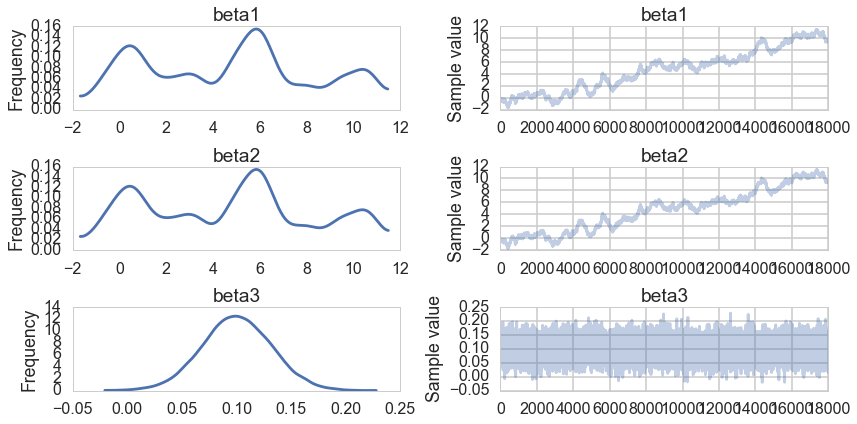

In [11]:
pm.traceplot(traceuni[10000::5]);

In [14]:
pm.summary(traceuni[10000::5])


beta1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.674            3.509            0.350            [-0.717, 10.769]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.770         1.196          5.056          6.880          10.733


beta2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.675            3.509            0.350            [-0.693, 10.793]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.777         1.201          5.055          6.878          10.730


beta3:

  Mean             SD               MC Error         95% HPD interval
  -------------------

Notice that the traces for $\beta_1$ and $\beta_2$ tell us that these are unidentifiable due to the nature of our true model, $\beta_3$ samples just fine.

## Ridge Regression

We get the same unidentifiability when we carry out a ridge regression in MCMC:

In [17]:
with pm.Model() as ridge:
    beta1 = pm.Normal('beta1', mu=0, tau=1.0)
    beta2 = pm.Normal('beta2', mu=0, tau=1.0)
    beta3 = pm.Normal('beta3', mu=0, tau=1.0)
    mu = beta1*x1 + beta2*x2 + beta3*x3
    ys = pm.Normal('ys', mu=mu, tau=1.0, observed=y)
    stepper=pm.Metropolis()
    traceridge = pm.sample(100000, step=stepper)
    

100%|██████████| 100000/100000 [00:28<00:00, 3487.86it/s]| 68/100000 [00:00<02:27, 679.28it/s]


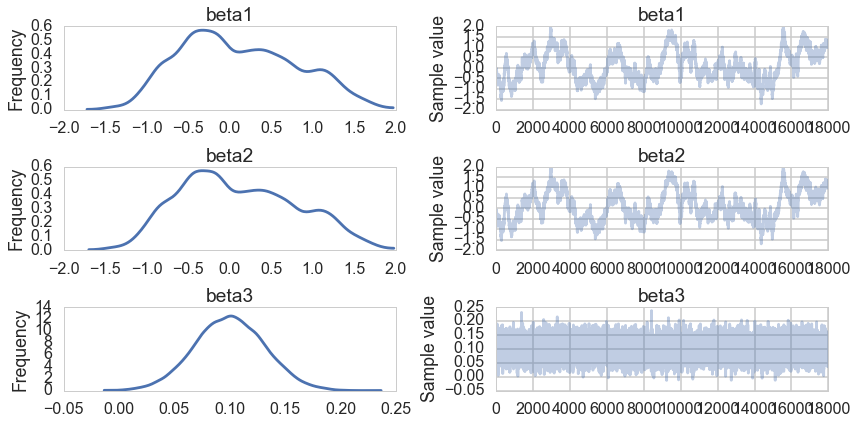

In [18]:
pm.traceplot(traceridge[10000::5]);

In [19]:
pm.summary(traceridge[10000::5])


beta1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.109            0.696            0.065            [-1.095, 1.394]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.034         -0.435         0.027          0.627          1.471


beta2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.109            0.697            0.065            [-1.098, 1.395]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.039         -0.433         0.031          0.628          1.478


beta3:

  Mean             SD               MC Error         95% HPD interval
  -----------------------

Just like in MCMC with a uniform prior, $\beta3$ is well behaved. The traces for $\beta_1$ and $\beta_2$ are poor.

However, remember that our posterior now has an additional gaussian multiplied in, and we can find the MAP estimate of our posterior:

In [22]:
with ridge:
    mapridge = pm.find_MAP()

Optimization terminated successfully.
         Current function value: 921.748306
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7


In [23]:
mapridge

{'beta1': array(0.004526796692482796),
 'beta2': array(0.005064112237104185),
 'beta3': array(0.10005872308519308)}

The MAPs of $\beta_1$ and $\beta_2$ dont match on the traceplot: this is not surprising as those chains wont converge due to non-identifiability. But notice that the MAP values themselves are suppressed as compared to 10. This is the effect of the ridge or the gaussian prior at 0: they are forcing the coefficient values down.

## Lasso Regression

Lasso as we know it in conventional stats is the idea of adding a $L_1$ penalization to the risk. This corresponds to a laplace prior. Below we add a prior with the same variance as a corresponding Gaussian. We notice that its narrower and more peaked at 0.

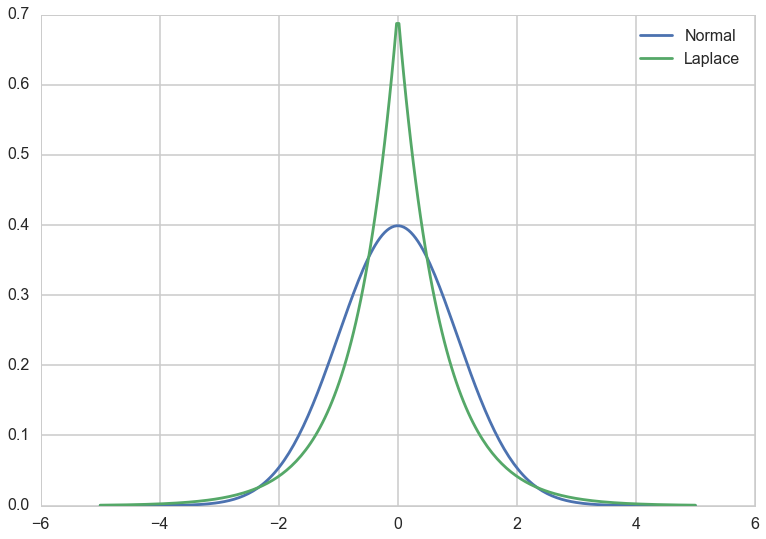

In [26]:
from scipy.stats import laplace

sigma2 = 1.0
b = 1.0 / np.sqrt(2.0 * sigma2)

xs = np.linspace(-5, 5, 250)
plt.plot(xs, norm.pdf(xs), label='Normal');
plt.plot(xs, laplace.pdf(xs, scale=b), label='Laplace');
plt.legend();

In [27]:
with pm.Model() as lasso:
    beta1 = pm.Laplace('beta1', mu=0, b=b)
    beta2 = pm.Laplace('beta2', mu=0, b=b)
    beta3 = pm.Laplace('beta3', mu=0, b=b)
    mu = beta1*x1 + beta2*x2 + beta3*x3
    ys = pm.Normal('ys', mu=mu, tau=1.0, observed=y)
    stepper=pm.Metropolis()
    tracelasso = pm.sample(100000, step=stepper)
    

100%|██████████| 100000/100000 [00:28<00:00, 3532.99it/s]| 287/100000 [00:00<00:34, 2868.94it/s]


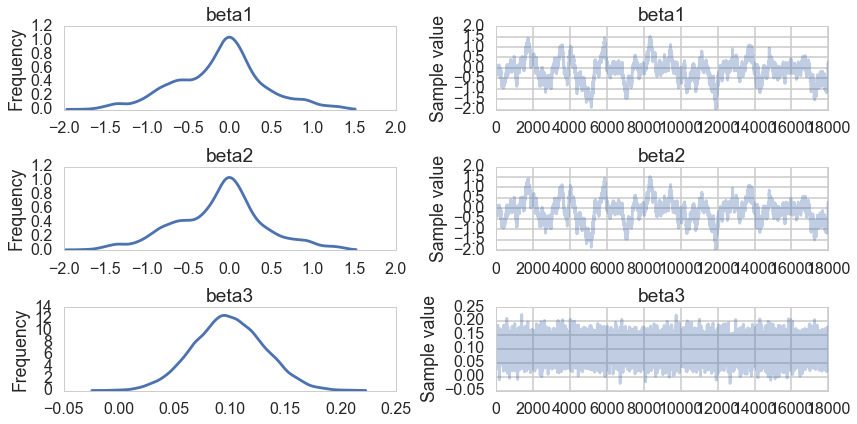

In [30]:
pm.traceplot(tracelasso[10000::5]);

In [31]:
pm.summary(tracelasso[10000::5])


beta1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.117           0.538            0.049            [-1.193, 1.043]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.284         -0.459         -0.066         0.177          0.984


beta2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.116           0.538            0.049            [-1.211, 1.027]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.277         -0.460         -0.065         0.179          0.989


beta3:

  Mean             SD               MC Error         95% HPD interval
  -----------------------

Notice that our non-identifiablity problems remain. But in the MAP estimates, and as can even be seen in our traces for once (in other words our sampling is doing better here), $\beta_1$ and $\beta_2$ are highly suppressed. The peaked laplace prior has the effect of setting some coefficients to exactly 0.

In [32]:
with lasso:
    maplasso = pm.find_MAP()

         Current function value: 920.168162
         Iterations: 2
         Function evaluations: 48
         Gradient evaluations: 44


In [33]:
maplasso

{'beta1': array(-7.255541060919206e-05),
 'beta2': array(8.485263161675386e-05),
 'beta3': array(0.10015818579834601)}